In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pystan
from pystan import StanModel 
from numpy import polyval, place, extract, any, asarray, nan, inf, pi
from numpy import (where, arange, putmask, ravel, sum, shape,
                   log, sqrt, exp, arctanh, tan, sin, arcsin, arctan,
                   tanh, cos, cosh, sinh, log1p, expm1)

from scipy.stats import rv_continuous
from scipy.stats import f
from prettytable import PrettyTable
import datetime
import os # to save file to a selected directories, which do not need to be created
import scipy.special as ss


class frechet_gen(rv_continuous):
#     def _argcheck(self, c):
#         c = asarray(c)
#         self.b = where(c < 0, 1.0/abs(c), inf)
#         return where(c == 0, 0, 1)

#     def _pdf(self, x, alpha1, alpha2, beta):
#         Px = 1 / beta / ss.beta(alpha1, alpha2) * pow(x/beta, asarray(alpha1-1.0)) * pow(1 + x/beta, asarray(- alpha1 - alpha2))
#         return Px

#     def _logpdf(self, x, alpha1, alpha2, beta):
#         return (alpha1 - 1) * np.log(x) - alpha1 * np.log(beta) - np.log(ss.beta(alpha1, alpha2)) - (alpha1 + alpha2) * np.log(1 + x/beta)

    def _cdf(self, x, beta):
        return exp(-pow(x, -1/beta))
#     def _ppf(self, q, c):
#         vals = 1.0/c * (pow(1-q, -c)-1)
#         return vals

#     def _munp(self, n, c):
#         k = arange(0, n+1)
#         val = (-1.0/c)**n * sum(comb(n, k)*(-1)**k / (1.0-c*k), axis=0)
#         return where(c*n < 1, val, inf)

#     def _entropy(self, c):
#         if (c > 0):
#             return 1+c
#         else:
#             self.b = -1.0 / c
#             return rv_continuous._entropy(self, c)
frechet = frechet_gen(a=0.0, name='frechet') # we specify the support [a,b], no b means b = infinity

In [2]:
q = [0.98, 0.99, 0.995, 0.999, 0.9995]
beta_frechet = 1/2
quant_th = np.zeros(len(q))
for i in range(len(q)):
    quant_th[i] = pow(-log(q[i]), -beta_frechet)

def PWM_GPD(excesses, k, u):
    quant_PWM_GPD = np.zeros(len(q))
    sum1, sum2 = 0, 0
    for i in range(k):
        sum1 += excesses[i]
        sum2 += i * excesses[i]
    mu0 = sum1 / k
    mu1 = sum1 / k - sum2 / k / k
    for i in range(len(q)):
        quant_PWM_GPD[i] = u + (2 * mu1 * mu0) / (mu0 - 4 * mu1) *( pow( N * (1-q[i]) / k, -(4 * mu1 - mu0) / (2 * mu1 - mu0) ) - 1 ) 
    return(quant_PWM_GPD)
             
def quantiles_GPD(excesses, k, u): 
    """ 
    we forward to function array of the quantiles as excesses, the number of excesses, k, and the border value u
    """
    quant_GPD = np.zeros(len(q)) 
    bayesian_quant_GPD = np.zeros(len(q))
    median_quant_GPD = np.zeros(1500)
    all_median_quant_GPD = np.zeros(1500)
    
    # here we fit GPD to excesses via PyStan
    data = dict(N = k,  y = excesses) 
    fit = StanModel(model_code=GPD).sampling(data=data,iter=2000,warmup=500, chains=1) 
    
    # we save the params from the fit to calculate GPD quantiles and their traceplots to calculate Bayesian GPD quantiles
    traceplot_beta_GPD = list(fit.extract().values())[1].tolist() 
    traceplot_alpha = list(fit.extract().values())[0].tolist()
    traceplot_gamma = np.divide(np.ones(len(traceplot_alpha)), traceplot_alpha)
    beta_GPD = np.mean(list(fit.extract().values())[1].tolist())
    alpha = np.mean(list(fit.extract().values())[0].tolist())
    gamma = 1 / alpha 
    
    for i in range(len(q)):
        quant_GPD[i] = u + beta_GPD*( pow( N * (1-q[i]) / k, -gamma ) - 1 ) 
        for j in range(len(traceplot_gamma)):
            bayesian_quant_GPD[i] += u + traceplot_beta_GPD[j] * (pow( N * (1 - q[i]) / k, - traceplot_gamma[j] ) - 1)
            median_quant_GPD[j] = u + traceplot_beta_GPD[j] * (pow( N * (1 - q[i]) / k, - traceplot_gamma[j] ) - 1)
        all_median_quant_GPD = np.column_stack((all_median_quant_GPD, median_quant_GPD))
    bayesian_quant_GPD = bayesian_quant_GPD / len(traceplot_gamma)
    all_median_quant_GPD = np.delete(all_median_quant_GPD, 0, 1)
#     for j in ran?ge(len(traceplot_gamma)):
    store_medians = np.zeros(len(q))
    #taking a median of quantiles compyted in Bayesian method
    for i in range(len(q)):
        store_medians[i] = np.median(all_median_quant_GPD[:,i])
        
    list_of_params = [alpha, beta_GPD]
    return(quant_GPD, bayesian_quant_GPD, list_of_params,store_medians ) 
# it return arrays: quant_GPD, bayesian_quant_GPD and values alpha, beta_GPD

def quantiles_Fisher(excesses, k, u):
    quant_Fisher = np.zeros(len(q)) 
    bayesian_quant_Fisher = np.zeros(len(q))
    median_quant_Fisher = np.zeros(1500)
    all_median_quant_Fisher = np.zeros(1500)
    
    # here we fit Fisher to excesses via PyStan
    data = dict(N = k,  y = excesses) 
    fit = StanModel(model_code=Fisher).sampling(data=data,iter=2000,warmup=500, chains=1) 
    
    # we save the params from the fit to calculate Fisher quantiles and their traceplots to calculate Bayesian Fisher quantiles
    traceplot_alpha1 = list(fit.extract().values())[0].tolist()
    traceplot_alpha2 = list(fit.extract().values())[1].tolist()
    traceplot_beta = list(fit.extract().values())[2].tolist()
    
    alpha1 = np.mean(list(fit.extract().values())[0].tolist())
    alpha2 = np.mean(list(fit.extract().values())[1].tolist())
    beta = np.mean(list(fit.extract().values())[2].tolist())
    
    beta0 = alpha2/alpha1
    
    for i in range(len(q)):
        quant_Fisher[i] = u +  f.isf(N / k * (1 - q[i]), 2 * alpha1, 2 * alpha2, loc = 0, scale = beta / beta0)
        for j in range(len(traceplot_alpha1)):
            bayesian_quant_Fisher[i] += u + f.isf(N / k * ( 1- q[i] ), 2 * traceplot_alpha1[j], 2 * traceplot_alpha2[j], loc=0, scale= ( traceplot_alpha1[j] * traceplot_beta[j]) / traceplot_alpha2[j] )
            median_quant_Fisher[j] = u + f.isf(N / k * ( 1- q[i] ), 2 * traceplot_alpha1[j], 2 * traceplot_alpha2[j], loc=0, scale= ( traceplot_alpha1[j] * traceplot_beta[j]) / traceplot_alpha2[j] )
        all_median_quant_Fisher = np.column_stack((all_median_quant_Fisher, median_quant_Fisher))

    bayesian_quant_Fisher = bayesian_quant_Fisher / len(traceplot_alpha1)
    all_median_quant_Fisher = np.delete(all_median_quant_Fisher, 0, 1)

    store_medians = np.zeros(len(q))
    #taking a median of quantiles compyted in Bayesian method
    for i in range(len(q)):
        store_medians[i] = np.median(all_median_quant_Fisher[:,i])

    
    list_of_params = [alpha1, alpha2, beta]
    return(quant_Fisher, bayesian_quant_Fisher, list_of_params,traceplot_alpha1,store_medians) 
# it return arrays: quant_Fisher, bayesian_quant_Fisher and values of params as a list


In [3]:
def plot_table(k, averaged_bayesian_quant_Fisher, 
               averaged_quant_Fisher, 
               averaged_bayesian_quant_GPD, 
               averaged_quant_GPD,
               median_GPD,
               median_Fisher, 
               PWM,
               now, repetitions, nb_thresholds):
    m = "5" # how much we round
    rounding = "%." + m + "f"
    m = int(m)
    t_quantiles = PrettyTable(["# of excesses k = " +  str(k),  
                               'mean', 
                               'sd',
                               str(q[0] * 100) + "%", 
                               str(q[1] * 100) + "%",
                               str(q[2] * 100) + "%",
                               str(q[3] * 100) + "%",
                               str(q[4] * 100) + "%"])
    t_quantiles.add_row(['theoretically', '--', '--',
                         rounding % round(quant_th[0],m),  
                         rounding % round(quant_th[1], m), 
                         rounding % round(quant_th[2], m),
                         rounding % round(quant_th[3], m),
                         rounding % round(quant_th[4], m) ])
    t_quantiles.add_row(['Bayes Fisher',  '--', '--',
                         rounding % round(averaged_bayesian_quant_Fisher[0],m),  
                         rounding % round(averaged_bayesian_quant_Fisher[1], m), 
                         rounding % round(averaged_bayesian_quant_Fisher[2], m),
                         rounding % round(averaged_bayesian_quant_Fisher[3], m),
                         rounding % round(averaged_bayesian_quant_Fisher[4], m) ])
    t_quantiles.add_row(['Fisher',  '--', '--',
                         rounding % round(averaged_quant_Fisher[0],m),  
                         rounding % round(averaged_quant_Fisher[1], m), 
                         rounding % round(averaged_quant_Fisher[2], m),
                         rounding % round(averaged_quant_Fisher[3], m),
                         rounding % round(averaged_quant_Fisher[4], m) ])
    t_quantiles.add_row(['median Fisher',  '--', '--',
                         rounding % round(median_Fisher[0],m),  
                         rounding % round(median_Fisher[1], m), 
                         rounding % round(median_Fisher[2], m),
                         rounding % round(median_Fisher[3], m),
                         rounding % round(median_Fisher[4], m) ])
    t_quantiles.add_row(['Bayes GPD', '--', '--',
                         rounding % round(averaged_bayesian_quant_GPD[0],m),  
                         rounding % round(averaged_bayesian_quant_GPD[1], m), 
                         rounding % round(averaged_bayesian_quant_GPD[2], m),
                         rounding % round(averaged_bayesian_quant_GPD[3], m),
                         rounding % round(averaged_bayesian_quant_GPD[4], m) ])
    t_quantiles.add_row(['GPD',  '--', '--',
                         rounding % round(averaged_quant_GPD[0],m),  
                         rounding % round(averaged_quant_GPD[1], m), 
                         rounding % round(averaged_quant_GPD[2], m),
                         rounding % round(averaged_quant_GPD[3], m),
                         rounding % round(averaged_quant_GPD[4], m) ])
    t_quantiles.add_row(['median GPD',  '--', '--',
                         rounding % round(median_GPD[0],m),  
                         rounding % round(median_GPD[1], m), 
                         rounding % round(median_GPD[2], m),
                         rounding % round(median_GPD[3], m),
                         rounding % round(median_GPD[4], m) ])
    t_quantiles.add_row(['PWM GPD',  '--', '--',
                         rounding % round(PWM[0],m),  
                         rounding % round(PWM[1], m), 
                         rounding % round(PWM[2], m),
                         rounding % round(PWM[3], m),
                         rounding % round(PWM[4], m) ])
    data = t_quantiles.get_string()
    # ---------------
    dir_name = str(now.day) + "_" + str(now.month) + "_" + str(now.year) + "_at_" + str(now.hour) + "_" + str(now.minute)
    script_dir = os.path.dirname('__file__')
    results_dir = os.path.join(script_dir, dir_name + '/')
    if not os.path.isdir(results_dir):
        os.makedirs(results_dir)
    with open(results_dir +   "repetitions_" + str(repetitions) + "_nb_thresholds_" + str(nb_thresholds) + '.txt', 'w') as f:
        f.write(data)
    # ---------------
    return(print(t_quantiles))

def compare_quantiles(jump_excesses, GPD, BGPD, Fisher, BFisher, median_GPD, median_Fisher, PWM,
                      theoretical_quantile,  quantile_level, now):
#     dir_name = str(now.day) + "_" + str(now.month) + "_" + str(now.year) + " at " + str(now.hour) + ":" + str(now.minute)
#     name = " quant level: " + str(q[quantile_level])
    #------
    dir_name = str(now.day) + "_" + str(now.month) + "_" + str(now.year) + "_at_" + str(now.hour) + "_" + str(now.minute)
    name = " quant_level_" + str(q[quantile_level])
    script_dir = os.path.dirname('__file__')
    results_dir = os.path.join(script_dir, dir_name + '/')
    sample_file_name = name + '.pdf'
    fig = plt.figure()
    if not os.path.isdir(results_dir): # if the directory does not exist we create it 
        os.makedirs(results_dir)
    ax = fig.add_subplot(111)
    fig.savefig(results_dir + sample_file_name )  
    #------
    plt.hlines(y=theoretical_quantile[quantile_level], 
               xmin=min(jump_excesses), 
               xmax=max(jump_excesses), 
               color='gray', 
               zorder=1, 
               label='theoretical value')

    plt.plot(jump_excesses, GPD[quantile_level,:],  'deepskyblue', label='GPD')
    plt.plot(jump_excesses, BGPD[quantile_level,:], 'darkblue', label='BGPD') 
    plt.plot(jump_excesses, median_GPD[quantile_level,:], 'aqua', label='median GPD')
    plt.plot(jump_excesses, Fisher[quantile_level,:], 'red', label='Fisher') 
    plt.plot(jump_excesses, BFisher[quantile_level,:], 'darkred', label='BFisher') 
    plt.plot(jump_excesses, median_Fisher[quantile_level,:], 'coral', label='median Fisher')
    plt.plot(jump_excesses, PWM[quantile_level,:], 'lime', label='PWM GPD')

    plt.xlabel('number of excesses')
    plt.ylabel('value of quantile at level ' + str(q[quantile_level]))
    plt.title('Variability of quantile at level ' + str(q[quantile_level])  )
    plt.legend()
    plt.savefig(results_dir + sample_file_name)
    return(plt.show())

def k_greatest_values_matrices(a,k):
    """returns k greatest elements from the list a and k - 1 value starting from which we consider greater values as extremes"""
    # we prepare the matrix for the excesses, the last value of 1 could be substituted by any value within the range
    mat = np.zeros( len(a[-1 - k + 1 : , 1] ) ) 
    # we prepare the vector in which we will return u values for each dataset in column of a
    u = np.zeros(len(r[0 , : ] )) 
    for i in range(len(a[0,:])): 
        # index i goes through the columns, instead of len(a[0,:]) there could be len(a[i,:]) for i in range of columns
        u[i] = a[-1 - k, i] 
        # u is a list of values s.t. bigger values are considered as excesses, for each set of data, i.e. for each column we save an u value
        mat = np.column_stack( (mat,a[ -1 - k + 1 : , i]) ) 
    # in mat matrix we return the values of excesses but not yet transformed (y_i = x_i - u)
    return(mat, u) # u is the starting value from which we consider others as excesses

In [4]:
n = 20 # number of sampled dataset over which we average the quantiles
N = 1000

r = frechet.rvs(beta_frechet, size=N)
for i in range(n):
    r = np.column_stack( (r, frechet.rvs(beta_frechet, size=N) ) ) 

# we need to sort in increasing order sampled data
for i in range(len(r[0,:])):
    r[:,i] = np.sort(r[:,i], axis=None)

In [5]:
GPD = """
functions {
  real myGPD_lpdf(real y, real alpha, real beta) {
      return -(alpha + 1)*( log(1+y/beta) )+(log(alpha) - log(beta));
  } 
}
data { 
  int N;
  real y[N];
}
parameters { 
  real<lower = 0> alpha;
  real<lower = 0> beta; // we set the bounderies for the computational facility
}
model {
// Priors here to be defined; no priors - we assume improper priors on params
//  alpha ~ gamma(1,1);
//  beta ~ gamma(1,1);

  target += -log(alpha + 1) - 1/2 * (log(alpha) + log(alpha + 2)); 
  target += log(1/beta);

// Likelihood
  for(n in 1:N) {
    target += myGPD_lpdf( y[n] | alpha, beta );
  }
}
generated quantities{}
"""

Fisher = """
functions { 
 real myFisher_lpdf(real y, real alpha1, real alpha2, real beta) {
      return -lbeta(alpha1,alpha2)-log(beta)+(alpha1-1)*log(y/beta)-(alpha1+alpha2)*log(1+y/beta);
  }
}
data { 
  int N;
  real y[N]; 
}
parameters { 
  //parameters of the Fisher
  real<lower=1> alpha1;
  real<lower=0> alpha2;
  real<lower=0> beta; 
}

model {
  // when we deliberately do not specify priors then Stan works with improper priors

  //alpha1 ~ gamma(10,10);
  target += - 2 * log(alpha1);
  target += -log(alpha2 + 1) - 1/2 * (log(alpha2) + log(alpha2 + 2));
  target += log(1/beta);

// Likelihood
  for(n in 1:N) {
    target += myFisher_lpdf( y[n] |alpha1, alpha2, beta);
  }
}
generated quantities{}
"""

In [6]:
how_many_different_thresholds = 15
min_thresholds = 100
max_thresholds = 500

# astype function converts the values in the array to integers
jump_excesses = np.linspace(min_thresholds, max_thresholds, how_many_different_thresholds).astype(int) 

number_of_GPD_params = 2
number_of_Fisher_params = 3

averaged_params_GPD, averaged_params_Fisher =  np.zeros(number_of_GPD_params), np.zeros(number_of_Fisher_params)

now = datetime.datetime.now() # we take it globally to save all the tables and plots in one directory

# we initialize the matrices of quantiles with row of zeros, we need it to plot
concatenated_averaged_quant_GPD, concatenated_averaged_bayesian_quant_GPD = np.zeros(len(q)), np.zeros(len(q))
concatenated_averaged_quant_Fisher, concatenated_averaged_bayesian_quant_Fisher = np.zeros(len(q)), np.zeros(len(q))
concatenated_median_quant_BFisher, concatenated_median_quant_BGPD = np.zeros(len(q)), np.zeros(len(q))
concatenated_averaged_probability_weighted_moments_GPD = np.zeros(len(q))
probability_weighted_moments_GPD = np.zeros(len(q))

bank_params_Fisher = np.zeros(number_of_Fisher_params)
bank_alpha1_traceplots = np.zeros(1500)

super_concatenated_probability_weighted_moments_GPD = np.zeros(len(q))
super_concatenated_quant_GPD = np.zeros(len(q))
super_concatenated_bayesian_quant_GPD = np.zeros(len(q))
super_concatenated_quant_Fisher = np.zeros(len(q))
super_concatenated_bayesian_quant_Fisher = np.zeros(len(q))
super_concatenated_median_quant_BFisher = np.zeros(len(q))
super_concatenated_median_quant_BGPD = np.zeros(len(q))
bank_medians_GPD = np.zeros(len(q))
bank_medians_Fisher = np.zeros(len(q))


In [7]:
for j in range(len(jump_excesses)): # for different threshold of excesses
    k = jump_excesses[j]
    
    # in data frechet we keep the matrix of excesses
    # transferred r is a matrix with n sampled dataset from Frechet
    
    data_frechet, u = k_greatest_values_matrices(r,k) 

    # delete first column (indexed by 0) of a matrix A, to match the sizes 
    A = np.delete(data_frechet, 0, 1)

    # form the array of u values we create matrix, in columns we have repeated u values   
    B = [ [x] * k for x in u ] 

    # here we subtract u_i from excesses in each dataset
    C = np.array(A) - np.array(B).transpose() 
    
    # we create matrices which we will reinitialize after each change of thresholds
    # from them we will calculate quantiles 
    
    # error - 1st: we don't keep track of all the values for each threshold, 2nd these values should be returned from quantile functions
    
    averaged_probability_weighted_moments_GPD = np.zeros(len(q))
    averaged_quant_GPD, averaged_bayesian_quant_GPD = np.zeros(len(q)), np.zeros(len(q))
    averaged_quant_Fisher, averaged_bayesian_quant_Fisher = np.zeros(len(q)), np.zeros(len(q))
    averaged_medians_GPD, averaged_medians_Fisher = np.zeros(len(q)), np.zeros(len(q))
    
    for i in range(n): 
        # we fit GPD and Fisher distributions to excesses from each dataset
        excesses_array = C[:,i] 
        quant_GPD, bayesian_quant_GPD, params_GPD, medians_GPD = quantiles_GPD(excesses_array, k, u[i])
        quant_Fisher, bayesian_quant_Fisher, params_Fisher, trace_alpha1, medians_Fisher = quantiles_Fisher(excesses_array, k, u[i])
        probability_weighted_moments_GPD = PWM_GPD(excesses_array, k, u[i])
#         print("medians_GPD = ", medians_GPD, "\n medians_Fisher = ", medians_Fisher )
        
        averaged_medians_GPD += medians_GPD
        averaged_medians_Fisher += medians_Fisher
        
        averaged_quant_GPD += quant_GPD
        averaged_bayesian_quant_GPD += bayesian_quant_GPD
        averaged_params_GPD += params_GPD 
        averaged_probability_weighted_moments_GPD += probability_weighted_moments_GPD
        
        averaged_quant_Fisher += quant_Fisher
        averaged_bayesian_quant_Fisher += bayesian_quant_Fisher

        bank_params_Fisher = np.column_stack((bank_params_Fisher, params_Fisher))
        bank_alpha1_traceplots = np.column_stack((bank_alpha1_traceplots, trace_alpha1))

        # we save the values of the estimated quantiels for each replication of threshold 
        bank_medians_GPD = np.column_stack((bank_medians_GPD, medians_GPD))
        bank_medians_Fisher = np.column_stack((bank_medians_Fisher, medians_Fisher))

        averaged_params_Fisher += params_Fisher 
        
        super_concatenated_probability_weighted_moments_GPD = np.column_stack((super_concatenated_probability_weighted_moments_GPD, probability_weighted_moments_GPD))
        super_concatenated_quant_GPD = np.column_stack( (super_concatenated_quant_GPD, quant_GPD ) )
        super_concatenated_bayesian_quant_GPD = np.column_stack( (super_concatenated_bayesian_quant_GPD, bayesian_quant_GPD ) )
        super_concatenated_quant_Fisher = np.column_stack( (super_concatenated_quant_Fisher, quant_Fisher ) )
        super_concatenated_bayesian_quant_Fisher = np.column_stack( (super_concatenated_bayesian_quant_Fisher, bayesian_quant_Fisher ) )

    # saving median quantiles to forward it to the table
    
    averaged_quant_GPD = averaged_quant_GPD / n 
    averaged_bayesian_quant_GPD = averaged_bayesian_quant_GPD / n
    averaged_params_GPD = asarray(averaged_params_GPD) / n
    averaged_probability_weighted_moments_GPD = averaged_probability_weighted_moments_GPD / n
    
    averaged_medians_GPD = averaged_medians_GPD / n
    averaged_medians_Fisher = averaged_medians_Fisher / n
    
    averaged_quant_Fisher = averaged_quant_Fisher / n 
    averaged_bayesian_quant_Fisher = averaged_bayesian_quant_Fisher / n
    averaged_params_Fisher = asarray(averaged_params_Fisher) / n
    

    plot_table(jump_excesses[j], 
           averaged_bayesian_quant_Fisher, 
           averaged_quant_Fisher, 
           averaged_bayesian_quant_GPD, 
           averaged_quant_GPD,
           averaged_medians_GPD,
           averaged_medians_Fisher,
           averaged_probability_weighted_moments_GPD, 
           now, n, how_many_different_thresholds)
    
    print(" Current number of excesses k = " + str(jump_excesses[j]), 
          "\n", "averaged_params_GPD: ", averaged_params_GPD, 
          "\n", "averaged_params_Fisher: ", averaged_params_Fisher)    
    
    #preparing to plot
    concatenated_averaged_probability_weighted_moments_GPD= np.column_stack((concatenated_averaged_probability_weighted_moments_GPD, averaged_probability_weighted_moments_GPD))
    concatenated_averaged_quant_GPD = np.column_stack( (concatenated_averaged_quant_GPD, averaged_quant_GPD ) )
    concatenated_averaged_bayesian_quant_GPD = np.column_stack( (concatenated_averaged_bayesian_quant_GPD, averaged_bayesian_quant_GPD ) )
    concatenated_averaged_quant_Fisher = np.column_stack( (concatenated_averaged_quant_Fisher, averaged_quant_Fisher ) )
    concatenated_averaged_bayesian_quant_Fisher = np.column_stack( (concatenated_averaged_bayesian_quant_Fisher, averaged_bayesian_quant_Fisher ) )
    concatenated_median_quant_BFisher = np.column_stack( (concatenated_median_quant_BFisher, averaged_medians_Fisher ) )
    concatenated_median_quant_BGPD = np.column_stack( (concatenated_median_quant_BGPD, averaged_medians_GPD ) )
    

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
C:\Users\Michal Lewandowski\Anaconda3\envs\py35\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C

+-----------------------+------+----+---------+----------+----------+----------+----------+
| # of excesses k = 100 | mean | sd |  98.0%  |  99.0%   |  99.5%   |  99.9%   |  99.95%  |
+-----------------------+------+----+---------+----------+----------+----------+----------+
|     theoretically     |  --  | -- | 7.03550 | 9.97493  | 14.12443 | 31.61487 | 44.71577 |
|      Bayes Fisher     |  --  | -- | 7.04068 | 10.00333 | 14.55906 | 39.96301 | 66.53368 |
|         Fisher        |  --  | -- | 7.25204 | 10.14905 | 14.31326 | 33.64206 | 50.16289 |
|     median Fisher     |  --  | -- | 7.00610 | 9.81281  | 13.88973 | 33.22656 | 50.08323 |
|       Bayes GPD       |  --  | -- | 6.13331 | 9.05626  | 12.72118 | 30.45596 | 46.29357 |
|          GPD          |  --  | -- | 6.15998 | 8.86134  | 11.64482 | 24.36005 | 33.41564 |
|       median GPD      |  --  | -- | 6.07591 | 8.99585  | 12.28944 | 26.39675 | 37.14161 |
|        PWM GPD        |  --  | -- | 7.10775 | 9.87160  | 13.61382 | 28.58860 |

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84

+-----------------------+------+----+---------+----------+----------+----------+----------+
| # of excesses k = 128 | mean | sd |  98.0%  |  99.0%   |  99.5%   |  99.9%   |  99.95%  |
+-----------------------+------+----+---------+----------+----------+----------+----------+
|     theoretically     |  --  | -- | 7.03550 | 9.97493  | 14.12443 | 31.61487 | 44.71577 |
|      Bayes Fisher     |  --  | -- | 7.03396 | 10.12601 | 14.87516 | 40.20387 | 64.96732 |
|         Fisher        |  --  | -- | 7.18519 | 10.06938 | 14.21171 | 33.06495 | 48.65087 |
|     median Fisher     |  --  | -- | 6.96808 | 9.89329  | 14.18720 | 34.27721 | 51.30712 |
|       Bayes GPD       |  --  | -- | 6.32819 | 9.23965  | 13.48800 | 33.86331 | 52.62382 |
|          GPD          |  --  | -- | 6.16779 | 9.23513  | 12.59761 | 28.02495 | 40.36765 |
|       median GPD      |  --  | -- | 6.16247 | 8.91507  | 12.84261 | 29.42096 | 42.96242 |
|        PWM GPD        |  --  | -- | 7.04598 | 9.79059  | 13.54369 | 28.82759 |

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84

+-----------------------+------+----+---------+----------+----------+----------+----------+
| # of excesses k = 157 | mean | sd |  98.0%  |  99.0%   |  99.5%   |  99.9%   |  99.95%  |
+-----------------------+------+----+---------+----------+----------+----------+----------+
|     theoretically     |  --  | -- | 7.03550 | 9.97493  | 14.12443 | 31.61487 | 44.71577 |
|      Bayes Fisher     |  --  | -- | 7.04352 | 10.19881 | 15.02618 | 40.30175 | 64.52409 |
|         Fisher        |  --  | -- | 7.06634 | 10.01589 | 14.29803 | 34.00436 | 50.41547 |
|     median Fisher     |  --  | -- | 6.96799 | 9.94291  | 14.32985 | 34.99831 | 52.47575 |
|       Bayes GPD       |  --  | -- | 6.90320 | 9.82313  | 14.15499 | 34.78739 | 52.52946 |
|          GPD          |  --  | -- | 6.83558 | 9.50848  | 13.23597 | 29.62233 | 41.93273 |
|       median GPD      |  --  | -- | 6.83174 | 9.58784  | 13.48479 | 31.05827 | 44.52053 |
|        PWM GPD        |  --  | -- | 7.02494 | 9.78608  | 13.58147 | 29.10080 |

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84

+-----------------------+------+----+---------+----------+----------+----------+----------+
| # of excesses k = 185 | mean | sd |  98.0%  |  99.0%   |  99.5%   |  99.9%   |  99.95%  |
+-----------------------+------+----+---------+----------+----------+----------+----------+
|     theoretically     |  --  | -- | 7.03550 | 9.97493  | 14.12443 | 31.61487 | 44.71577 |
|      Bayes Fisher     |  --  | -- | 7.06411 | 10.20184 | 14.89877 | 37.81207 | 57.95040 |
|         Fisher        |  --  | -- | 7.07561 | 10.03513 | 14.27563 | 32.95584 | 47.72191 |
|     median Fisher     |  --  | -- | 6.98885 | 9.96390  | 14.27955 | 33.68846 | 49.31422 |
|       Bayes GPD       |  --  | -- | 7.10406 | 10.08284 | 14.34921 | 33.38906 | 48.78471 |
|          GPD          |  --  | -- | 7.02073 | 9.79434  | 13.61434 | 29.21409 | 40.70994 |
|       median GPD      |  --  | -- | 7.03789 | 9.87907  | 13.84342 | 30.33074 | 42.70058 |
|        PWM GPD        |  --  | -- | 7.01961 | 9.79336  | 13.61474 | 29.24622 |

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84

+-----------------------+------+----+---------+----------+----------+----------+----------+
| # of excesses k = 214 | mean | sd |  98.0%  |  99.0%   |  99.5%   |  99.9%   |  99.95%  |
+-----------------------+------+----+---------+----------+----------+----------+----------+
|     theoretically     |  --  | -- | 7.03550 | 9.97493  | 14.12443 | 31.61487 | 44.71577 |
|      Bayes Fisher     |  --  | -- | 7.08566 | 10.26759 | 15.03952 | 38.29041 | 58.60722 |
|         Fisher        |  --  | -- | 7.07938 | 10.07777 | 14.39409 | 33.50561 | 48.61776 |
|     median Fisher     |  --  | -- | 7.00905 | 10.03031 | 14.43284 | 34.25961 | 50.16258 |
|       Bayes GPD       |  --  | -- | 7.09716 | 10.09307 | 14.40565 | 33.85813 | 49.75008 |
|          GPD          |  --  | -- | 7.00696 | 9.80738  | 13.69973 | 29.90591 | 42.08144 |
|       median GPD      |  --  | -- | 7.02778 | 9.88671  | 13.89424 | 30.90671 | 43.85111 |
|        PWM GPD        |  --  | -- | 6.99888 | 9.77033  | 13.60000 | 29.35414 |

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84

+-----------------------+------+----+---------+----------+----------+----------+----------+
| # of excesses k = 242 | mean | sd |  98.0%  |  99.0%   |  99.5%   |  99.9%   |  99.95%  |
+-----------------------+------+----+---------+----------+----------+----------+----------+
|     theoretically     |  --  | -- | 7.03550 | 9.97493  | 14.12443 | 31.61487 | 44.71577 |
|      Bayes Fisher     |  --  | -- | 7.10472 | 10.26703 | 14.96030 | 37.24914 | 56.19091 |
|         Fisher        |  --  | -- | 7.07304 | 10.05792 | 14.33296 | 33.04449 | 47.66745 |
|     median Fisher     |  --  | -- | 7.01733 | 10.02943 | 14.39929 | 33.77645 | 49.16880 |
|       Bayes GPD       |  --  | -- | 7.08619 | 10.04773 | 14.27381 | 32.91878 | 47.79324 |
|          GPD          |  --  | -- | 6.98954 | 9.76409  | 13.59782 | 29.31419 | 40.91768 |
|       median GPD      |  --  | -- | 7.01583 | 9.84896  | 13.81341 | 30.32183 | 42.66820 |
|        PWM GPD        |  --  | -- | 6.99900 | 9.77908  | 13.62334 | 29.42554 |

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84

+-----------------------+------+----+---------+----------+----------+----------+----------+
| # of excesses k = 271 | mean | sd |  98.0%  |  99.0%   |  99.5%   |  99.9%   |  99.95%  |
+-----------------------+------+----+---------+----------+----------+----------+----------+
|     theoretically     |  --  | -- | 7.03550 | 9.97493  | 14.12443 | 31.61487 | 44.71577 |
|      Bayes Fisher     |  --  | -- | 7.10550 | 10.10596 | 14.48067 | 34.72845 | 51.59648 |
|         Fisher        |  --  | -- | 7.08632 | 9.95097  | 14.00532 | 31.53265 | 45.14510 |
|     median Fisher     |  --  | -- | 7.03570 | 9.91475  | 14.01636 | 31.96294 | 46.06531 |
|       Bayes GPD       |  --  | -- | 7.10280 | 10.05090 | 14.22802 | 32.32457 | 46.46351 |
|          GPD          |  --  | -- | 7.00471 | 9.77868  | 13.59973 | 29.14743 | 40.53392 |
|       median GPD      |  --  | -- | 7.03552 | 9.86398  | 13.79892 | 30.09011 | 42.16739 |
|        PWM GPD        |  --  | -- | 7.01592 | 9.80070  | 13.64321 | 29.35106 |

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84

+-----------------------+------+----+---------+----------+----------+----------+----------+
| # of excesses k = 300 | mean | sd |  98.0%  |  99.0%   |  99.5%   |  99.9%   |  99.95%  |
+-----------------------+------+----+---------+----------+----------+----------+----------+
|     theoretically     |  --  | -- | 7.03550 | 9.97493  | 14.12443 | 31.61487 | 44.71577 |
|      Bayes Fisher     |  --  | -- | 7.10901 | 10.21429 | 14.74893 | 35.50114 | 52.48486 |
|         Fisher        |  --  | -- | 7.07856 | 10.03465 | 14.23142 | 32.26370 | 46.10487 |
|     median Fisher     |  --  | -- | 7.03111 | 10.01098 | 14.27338 | 32.84907 | 47.28394 |
|       Bayes GPD       |  --  | -- | 7.07497 | 9.94920  | 13.96893 | 30.89507 | 43.74246 |
|          GPD          |  --  | -- | 6.97974 | 9.69784  | 13.40698 | 28.20678 | 38.83433 |
|       median GPD      |  --  | -- | 7.00464 | 9.77708  | 13.59058 | 29.03151 | 40.25353 |
|        PWM GPD        |  --  | -- | 7.02841 | 9.81113  | 13.64252 | 29.23350 |

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84

+-----------------------+------+----+---------+----------+----------+----------+----------+
| # of excesses k = 328 | mean | sd |  98.0%  |  99.0%   |  99.5%   |  99.9%   |  99.95%  |
+-----------------------+------+----+---------+----------+----------+----------+----------+
|     theoretically     |  --  | -- | 7.03550 | 9.97493  | 14.12443 | 31.61487 | 44.71577 |
|      Bayes Fisher     |  --  | -- | 7.10073 | 10.15221 | 14.55120 | 34.10381 | 49.63871 |
|         Fisher        |  --  | -- | 7.05481 | 9.96340  | 14.05202 | 31.23715 | 44.13503 |
|     median Fisher     |  --  | -- | 7.02571 | 9.95842  | 14.10968 | 31.77098 | 45.17321 |
|       Bayes GPD       |  --  | -- | 7.08298 | 9.96883  | 14.00493 | 30.97461 | 43.82505 |
|          GPD          |  --  | -- | 6.98611 | 9.71918  | 13.45340 | 28.36921 | 39.08156 |
|       median GPD      |  --  | -- | 7.01226 | 9.78989  | 13.60608 | 29.04318 | 40.23512 |
|        PWM GPD        |  --  | -- | 7.03256 | 9.82351  | 13.66645 | 29.27967 |

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84

+-----------------------+------+----+---------+----------+----------+----------+----------+
| # of excesses k = 357 | mean | sd |  98.0%  |  99.0%   |  99.5%   |  99.9%   |  99.95%  |
+-----------------------+------+----+---------+----------+----------+----------+----------+
|     theoretically     |  --  | -- | 7.03550 | 9.97493  | 14.12443 | 31.61487 | 44.71577 |
|      Bayes Fisher     |  --  | -- | 7.10568 | 10.15520 | 14.54358 | 33.97429 | 49.35428 |
|         Fisher        |  --  | -- | 7.05954 | 9.96866  | 14.05484 | 31.20919 | 44.07437 |
|     median Fisher     |  --  | -- | 7.03348 | 9.96620  | 14.11891 | 31.78044 | 45.14537 |
|       Bayes GPD       |  --  | -- | 7.07862 | 9.94722  | 13.94469 | 30.61061 | 43.11638 |
|          GPD          |  --  | -- | 6.98234 | 9.70714  | 13.42509 | 28.23597 | 38.84606 |
|       median GPD      |  --  | -- | 7.01047 | 9.78169  | 13.58227 | 28.90680 | 39.98577 |
|        PWM GPD        |  --  | -- | 7.03382 | 9.82503  | 13.66714 | 29.26354 |

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84

+-----------------------+------+----+---------+----------+----------+----------+----------+
| # of excesses k = 385 | mean | sd |  98.0%  |  99.0%   |  99.5%   |  99.9%   |  99.95%  |
+-----------------------+------+----+---------+----------+----------+----------+----------+
|     theoretically     |  --  | -- | 7.03550 | 9.97493  | 14.12443 | 31.61487 | 44.71577 |
|      Bayes Fisher     |  --  | -- | 7.10758 | 10.14173 | 14.49053 | 33.58496 | 48.57906 |
|         Fisher        |  --  | -- | 7.05758 | 9.95596  | 14.01676 | 30.97540 | 43.62935 |
|     median Fisher     |  --  | -- | 7.03478 | 9.95743  | 14.07725 | 31.51842 | 44.64341 |
|       Bayes GPD       |  --  | -- | 7.07488 | 9.92825  | 13.89306 | 30.32361 | 42.57971 |
|          GPD          |  --  | -- | 6.98060 | 9.69782  | 13.40032 | 28.10962 | 38.61921 |
|       median GPD      |  --  | -- | 7.01173 | 9.77437  | 13.55812 | 28.78177 | 39.75002 |
|        PWM GPD        |  --  | -- | 7.03766 | 9.82391  | 13.65465 | 29.17412 |

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84

+-----------------------+------+----+---------+----------+----------+----------+----------+
| # of excesses k = 414 | mean | sd |  98.0%  |  99.0%   |  99.5%   |  99.9%   |  99.95%  |
+-----------------------+------+----+---------+----------+----------+----------+----------+
|     theoretically     |  --  | -- | 7.03550 | 9.97493  | 14.12443 | 31.61487 | 44.71577 |
|      Bayes Fisher     |  --  | -- | 7.11110 | 10.13120 | 14.44287 | 33.20808 | 47.81055 |
|         Fisher        |  --  | -- | 7.06662 | 9.95905  | 14.00132 | 30.79445 | 43.26117 |
|     median Fisher     |  --  | -- | 7.03765 | 9.94961  | 14.05583 | 31.30140 | 44.21472 |
|       Bayes GPD       |  --  | -- | 7.06853 | 9.88589  | 13.77446 | 29.67039 | 41.37170 |
|          GPD          |  --  | -- | 6.97457 | 9.66181  | 13.30294 | 27.60835 | 37.72082 |
|       median GPD      |  --  | -- | 7.00327 | 9.73282  | 13.45020 | 28.18402 | 38.68773 |
|        PWM GPD        |  --  | -- | 7.05454 | 9.83613  | 13.64817 | 28.98300 |

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84

+-----------------------+------+----+---------+----------+----------+----------+----------+
| # of excesses k = 442 | mean | sd |  98.0%  |  99.0%   |  99.5%   |  99.9%   |  99.95%  |
+-----------------------+------+----+---------+----------+----------+----------+----------+
|     theoretically     |  --  | -- | 7.03550 | 9.97493  | 14.12443 | 31.61487 | 44.71577 |
|      Bayes Fisher     |  --  | -- | 7.11150 | 10.10380 | 14.35027 | 32.61814 | 46.68395 |
|         Fisher        |  --  | -- | 7.05578 | 9.92170  | 13.90839 | 30.33022 | 42.43091 |
|     median Fisher     |  --  | -- | 7.04275 | 9.93962  | 13.99198 | 30.78325 | 43.24950 |
|       Bayes GPD       |  --  | -- | 7.07019 | 9.89302  | 13.79199 | 29.75041 | 41.51027 |
|          GPD          |  --  | -- | 6.97365 | 9.66679  | 13.32085 | 27.71775 | 37.92478 |
|       median GPD      |  --  | -- | 7.00773 | 9.75166  | 13.49267 | 28.36500 | 38.96583 |
|        PWM GPD        |  --  | -- | 7.05001 | 9.83105  | 13.64452 | 29.00755 |

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84

+-----------------------+------+----+---------+----------+----------+----------+----------+
| # of excesses k = 471 | mean | sd |  98.0%  |  99.0%   |  99.5%   |  99.9%   |  99.95%  |
+-----------------------+------+----+---------+----------+----------+----------+----------+
|     theoretically     |  --  | -- | 7.03550 | 9.97493  | 14.12443 | 31.61487 | 44.71577 |
|      Bayes Fisher     |  --  | -- | 7.11849 | 10.11532 | 14.37022 | 32.70905 | 46.86718 |
|         Fisher        |  --  | -- | 7.06645 | 9.94184  | 13.94639 | 30.49313 | 42.72927 |
|     median Fisher     |  --  | -- | 7.04060 | 9.93776  | 13.99373 | 30.89638 | 43.49048 |
|       Bayes GPD       |  --  | -- | 7.05232 | 9.84251  | 13.67883 | 29.24190 | 40.61611 |
|          GPD          |  --  | -- | 6.95969 | 9.62985  | 13.24148 | 27.38699 | 37.36022 |
|       median GPD      |  --  | -- | 6.98801 | 9.69583  | 13.36981 | 27.88084 | 38.19347 |
|        PWM GPD        |  --  | -- | 7.05710 | 9.83226  | 13.63029 | 28.87275 |

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84674f2b73e091ee050c81d448413d NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2b225327d61dfa8314bbb8910dad1ea NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bd84

+-----------------------+------+----+---------+----------+----------+----------+----------+
| # of excesses k = 500 | mean | sd |  98.0%  |  99.0%   |  99.5%   |  99.9%   |  99.95%  |
+-----------------------+------+----+---------+----------+----------+----------+----------+
|     theoretically     |  --  | -- | 7.03550 | 9.97493  | 14.12443 | 31.61487 | 44.71577 |
|      Bayes Fisher     |  --  | -- | 7.11582 | 10.07919 | 14.25778 | 32.01102 | 45.52555 |
|         Fisher        |  --  | -- | 7.05886 | 9.90470  | 13.84617 | 29.95403 | 41.74257 |
|     median Fisher     |  --  | -- | 7.04302 | 9.91871  | 13.92153 | 30.43339 | 42.59515 |
|       Bayes GPD       |  --  | -- | 7.05741 | 9.84590  | 13.67550 | 29.16889 | 40.45832 |
|          GPD          |  --  | -- | 6.96483 | 9.63498  | 13.24426 | 27.35973 | 37.29645 |
|       median GPD      |  --  | -- | 6.99144 | 9.69425  | 13.37485 | 27.82071 | 38.06200 |
|        PWM GPD        |  --  | -- | 7.06059 | 9.83562  | 13.63086 | 28.83525 |

In [8]:
# we delete first column which was created as zeros
# we need those to plot quantiles on one plot and to compare them
concatenated_averaged_quant_GPD = np.delete(concatenated_averaged_quant_GPD, 0, 1)
concatenated_averaged_bayesian_quant_GPD = np.delete(concatenated_averaged_bayesian_quant_GPD, 0, 1)
concatenated_averaged_quant_Fisher = np.delete(concatenated_averaged_quant_Fisher, 0, 1)
concatenated_averaged_bayesian_quant_Fisher = np.delete(concatenated_averaged_bayesian_quant_Fisher, 0, 1)
concatenated_median_quant_BFisher = np.delete(concatenated_median_quant_BFisher, 0, 1)
concatenated_median_quant_BGPD = np.delete(concatenated_median_quant_BGPD, 0, 1)
concatenated_averaged_probability_weighted_moments_GPD = np.delete(concatenated_averaged_probability_weighted_moments_GPD, 0,1)

super_concatenated_probability_weighted_moments_GPD = np.delete(super_concatenated_probability_weighted_moments_GPD, 0, 1)
super_concatenated_quant_GPD = np.delete( super_concatenated_quant_GPD,  0, 1)
super_concatenated_bayesian_quant_GPD = np.delete( super_concatenated_bayesian_quant_GPD,  0, 1)
super_concatenated_quant_Fisher = np.delete( super_concatenated_quant_Fisher,  0, 1)
super_concatenated_bayesian_quant_Fisher = np.delete (super_concatenated_bayesian_quant_Fisher,  0, 1)
bank_medians_GPD = np.delete(bank_medians_GPD, 0, 1)
bank_medians_Fisher = np.delete(bank_medians_Fisher, 0, 1)

bank_params_Fisher = np.delete(bank_params_Fisher, 0, 1)
bank_alpha1_traceplots = np.delete(bank_alpha1_traceplots, 0, 1) 

In [9]:
#  function to make plots of traceplot and horizontal histogram of the traceplot in one row
param = "alpha1"
distr = "Fisher"

# print(bank_params_Fisher[0,:].reshape((n, how_many_different_thresholds))[1])
# each row corresponds to the same number of thresholds, each column corresponds to different dataset

def plot(traceplot, param, distr, nb_thres):
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=[14,8])
    # set x-axis name
    ax[0].set_xlabel("datasets")
    ax[0].plot(traceplot)
    ax[0].set_ylabel("value of " + param)
    # set y-axis name
    ax[1].set_xlabel("quantity of records")
    # ax[1].set_ylabel("number of records")

    plt.suptitle('alpha1 ' + distr + ' for ' + str(nb_thres) + ' thresholds ')
    # titles of subplots, here we don't use it 
    # ax[0].set_title("traceplot of beta in GPD(alpha, beta)")
    # ax[1].set_title("Values of beta in GPD(alpha, beta) fitted to the excesses from Frechet ")

    # create histogram within output
    Nb, bins, patches = ax[1].hist(traceplot, bins=50, color="#777777",  orientation="horizontal") #initial color of all bins
    return(plt.show())

In [10]:
def plot1(traceplot, param, distr, nb_thres):
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=[14,8])
    # set x-axis name
    ax[0].set_xlabel("datasets")
    ax[0].plot(traceplot)
    ax[0].set_ylabel("value of " + param)
    # set y-axis name
    ax[1].set_xlabel("quantity of records")
    # ax[1].set_ylabel("number of records")

    plt.suptitle('alpha1 ' + distr + ' for ' + str(nb_thres) + ' thresholds ')
    # titles of subplots, here we don't use it 
    # ax[0].set_title("traceplot of beta in GPD(alpha, beta)")
    # ax[1].set_title("Values of beta in GPD(alpha, beta) fitted to the excesses from Frechet ")

    # create histogram within output
    Nb, bins, patches = ax[1].hist(traceplot, bins=50, color="#777777",  orientation="horizontal") #initial color of all bins
    return(plt.show())

In [11]:
# for i in range(n * how_many_different_thresholds):
#     plot1(bank_alpha1_traceplots[:,i],  param, distr, jump_excesses[int(i % how_many_different_thresholds)] )


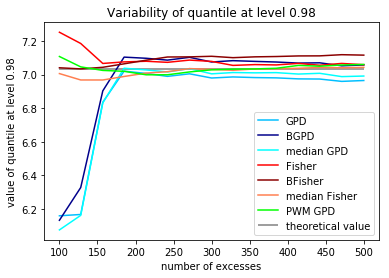

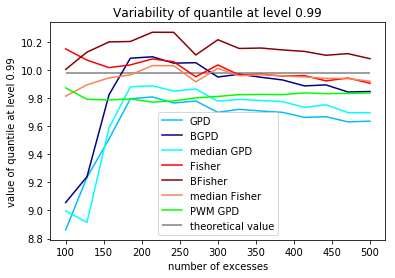

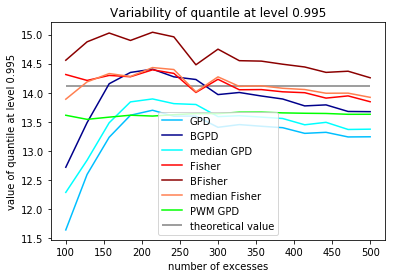

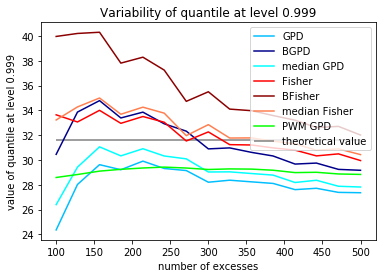

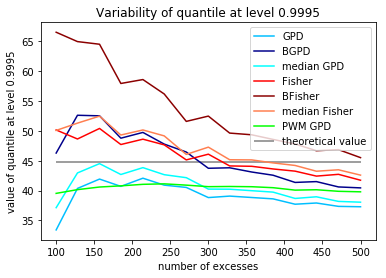

In [12]:
for i in range(len(q)):
    compare_quantiles(jump_excesses,
                  concatenated_averaged_quant_GPD, 
                  concatenated_averaged_bayesian_quant_GPD, 
                  concatenated_averaged_quant_Fisher,
                  concatenated_averaged_bayesian_quant_Fisher,
                  concatenated_median_quant_BGPD,
                  concatenated_median_quant_BFisher, 
                  concatenated_averaged_probability_weighted_moments_GPD,
                  quant_th,
                  i,now)

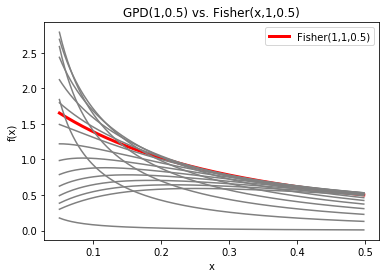

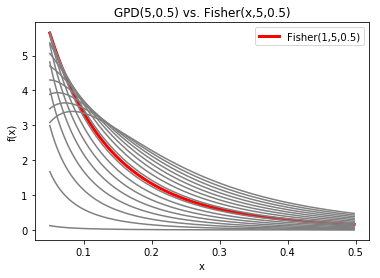

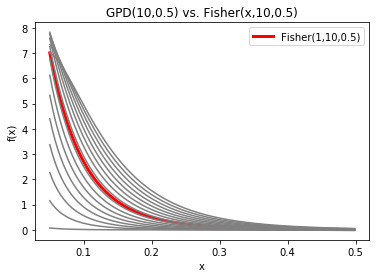

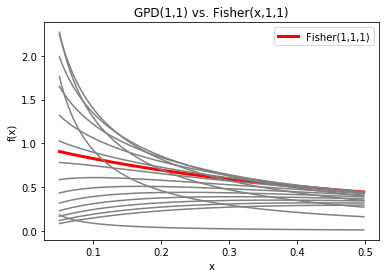

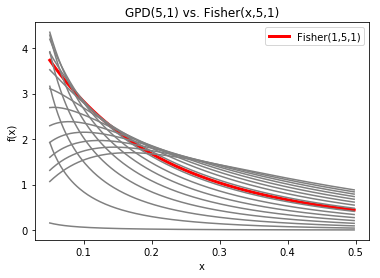

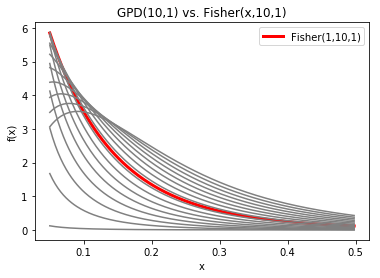

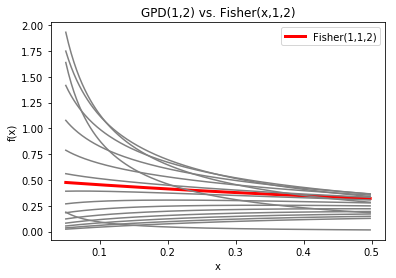

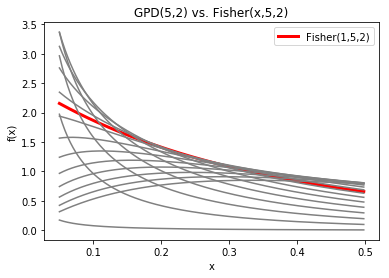

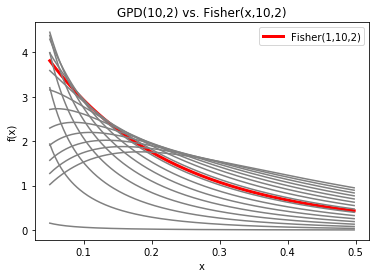

In [13]:
x = np.arange(0.05,0.5,0.002)
def GPD_pdf(x, alpha, beta):
    return alpha / beta * pow(1 + x / beta , - asarray(alpha)  - 1 )
def Fisher_pdf(x, alpha1, alpha2, beta):
    return 1 / beta / ss.beta(alpha1, alpha2) * pow(x / beta, asarray(alpha1) - 1) / pow(1 + x / beta, asarray(alpha1 + alpha2))


alpha1 = np.linspace(0.01, 2, 16)
# alpha1 = [0.25, 0.4, 0.55, 0.7, 0.85, 1.15, 1.3, 1.45, 1.6]
#
alpha2 = [1, 5, 10]
beta = [1/2, 1, 2]

for k in range(len(beta)):
    for j in range(len(alpha2)):
        dir_name = str(now.day) + "_" + str(now.month) + "_" + str(now.year) + "_at_" + str(now.hour) + "_" + str(now.minute)
        name = " comp_GPD_Fisher_" + str(alpha2[j]) + "_" + str(beta[k])
        script_dir = os.path.dirname('__file__')
        results_dir = os.path.join(script_dir, dir_name + '/')
        sample_file_name = name + '.pdf'
        fig = plt.figure()
        if not os.path.isdir(results_dir): # if the directory does not exist we create it 
            os.makedirs(results_dir)
        ax = fig.add_subplot(111)
        fig.savefig(results_dir + sample_file_name )
        #------------
        plt.plot(x, Fisher_pdf(x, 1, alpha2[j], beta[k]), linewidth=3.0, color='red', label='Fisher(1,'+ str(alpha2[j]) + ',' + str(beta[k]) + ')')
        for i in range(len(alpha1)):
            plt.plot(x, Fisher_pdf(x, alpha1[i], alpha2[j], beta[k]), 'gray')
            
        #------------
#         plt.hlines(y=quant_th[quantile_level], 
#                xmin=min(jump_excesses), 
#                xmax=max(jump_excesses), 
#                color='gray', 
#                zorder=1, 
#                label='theoretical value')
        #------------
        plt.xlabel('x')
        plt.ylabel('f(x)')
        title = "GPD(" + str(alpha2[j]) + ',' + str(beta[k]) + ') vs. Fisher(x,'+ str(alpha2[j]) + ',' + str(beta[k]) + ')' 
        # 'GPD(a,b) vs. Fisher(x,a,b)'
        plt.title(title )
        plt.savefig(results_dir + sample_file_name)
        plt.legend()
        plt.show()



In [14]:
list1 = [super_concatenated_probability_weighted_moments_GPD,
        super_concatenated_quant_GPD,
        super_concatenated_bayesian_quant_GPD,
        super_concatenated_quant_Fisher,
        super_concatenated_bayesian_quant_Fisher,
        bank_medians_GPD,
        bank_medians_Fisher ]
list1_names = ["PWM GPD",
        "GPD",
        "bayes GPD",
        "Fisher",
        "bayes Fisher",
        "median GPD",
        "median Fisher" ]

# for k in range(len(list1)): # for a given method
#     for j in range(len(q)): # choose a given quantile level
#         for i in range(n): # then choose and plot values obtained for each of the datasets
#             plt.plot(jump_excesses,  list1[k][j].reshape(n,how_many_different_thresholds)[i,:], 'gray')

#         plt.plot(jump_excesses, concatenated_median_quant_BGPD[j,:], 'red', label='averaged')
#         plt.xlabel('threshold ')
#         plt.ylabel('Value')

#         plt.title('q = ' + str(q[j]) + ' for ' + list1_names[k]+ ' for consecutive datasets (gray)' )
#         plt.legend()

#         plt.show()

C:\Users\Michal Lewandowski\Anaconda3\envs\py35\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 432x288 with 0 Axes>

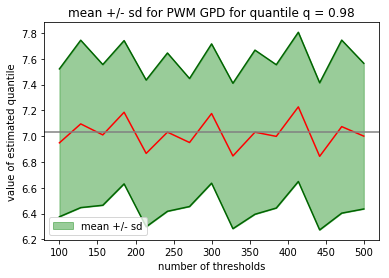

<Figure size 432x288 with 0 Axes>

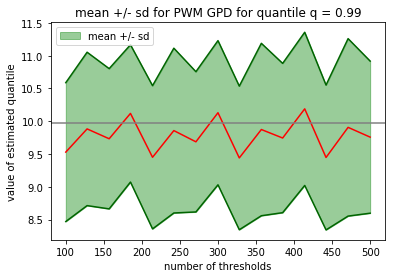

<Figure size 432x288 with 0 Axes>

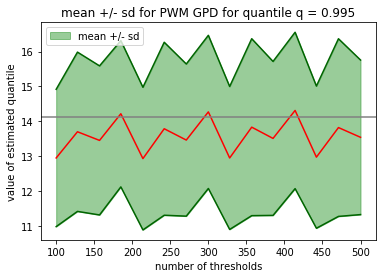

<Figure size 432x288 with 0 Axes>

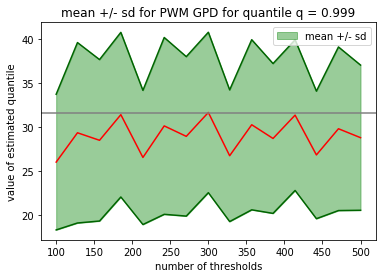

<Figure size 432x288 with 0 Axes>

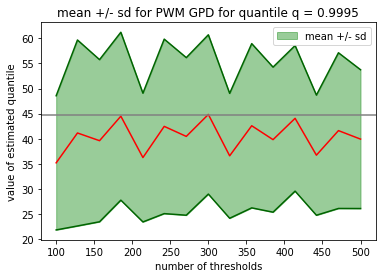

<Figure size 432x288 with 0 Axes>

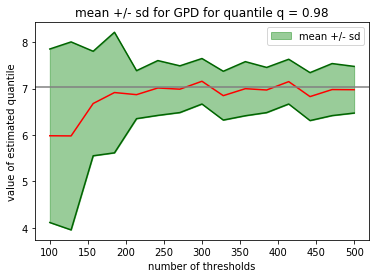

<Figure size 432x288 with 0 Axes>

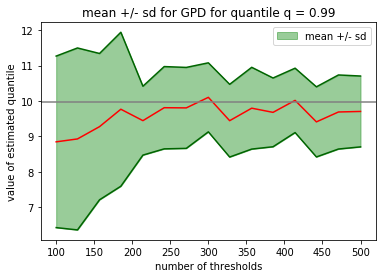

<Figure size 432x288 with 0 Axes>

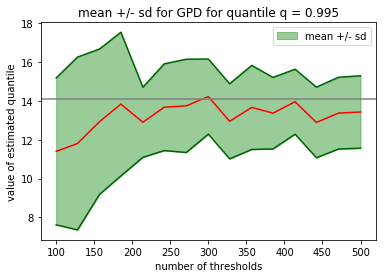

<Figure size 432x288 with 0 Axes>

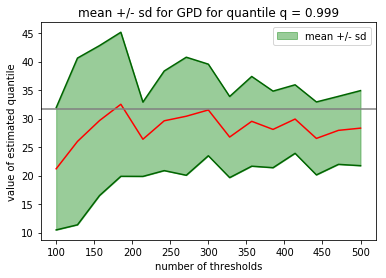

<Figure size 432x288 with 0 Axes>

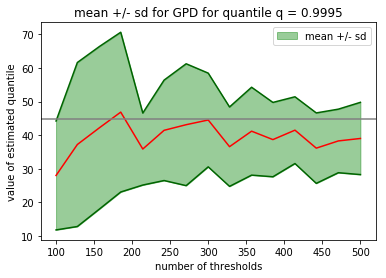

<Figure size 432x288 with 0 Axes>

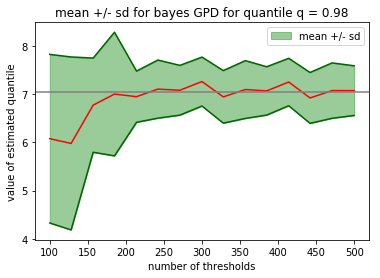

<Figure size 432x288 with 0 Axes>

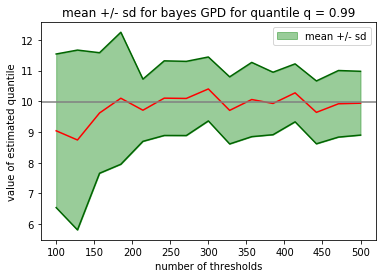

<Figure size 432x288 with 0 Axes>

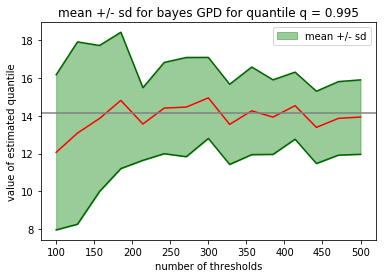

<Figure size 432x288 with 0 Axes>

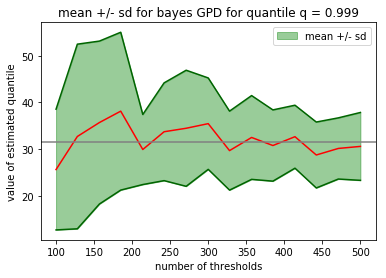

<Figure size 432x288 with 0 Axes>

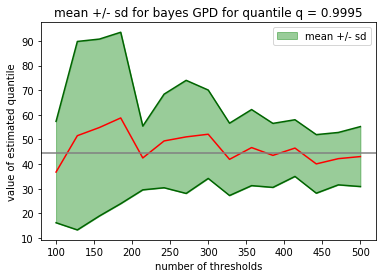

<Figure size 432x288 with 0 Axes>

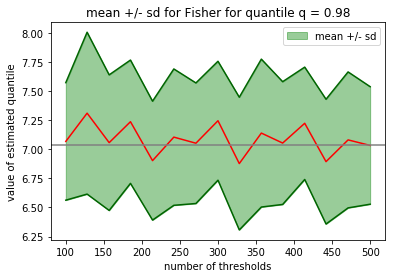

<Figure size 432x288 with 0 Axes>

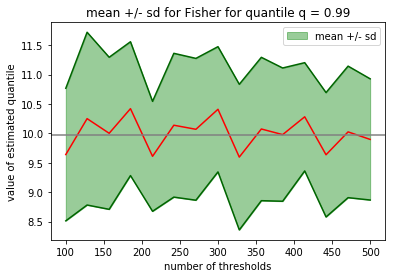

<Figure size 432x288 with 0 Axes>

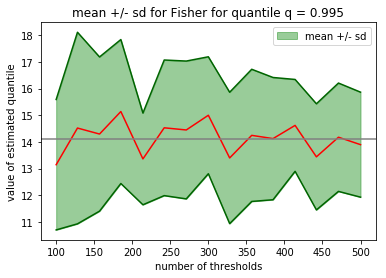

<Figure size 432x288 with 0 Axes>

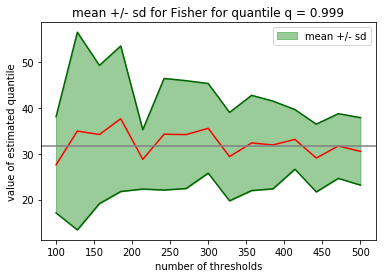

<Figure size 432x288 with 0 Axes>

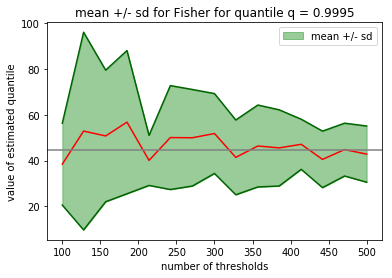

<Figure size 432x288 with 0 Axes>

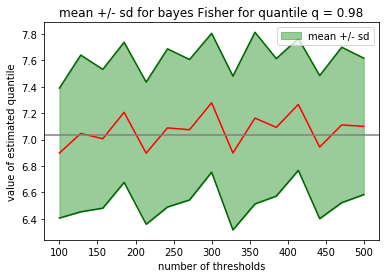

<Figure size 432x288 with 0 Axes>

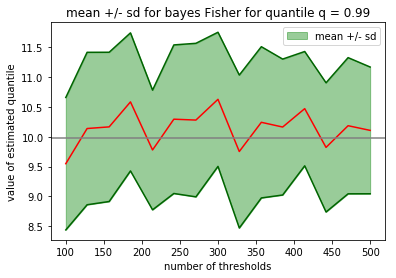

<Figure size 432x288 with 0 Axes>

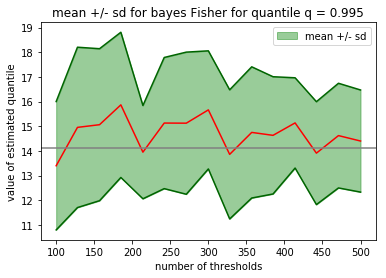

<Figure size 432x288 with 0 Axes>

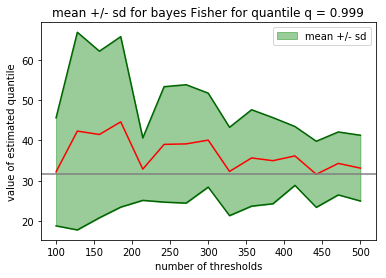

<Figure size 432x288 with 0 Axes>

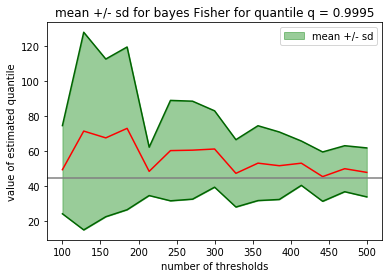

<Figure size 432x288 with 0 Axes>

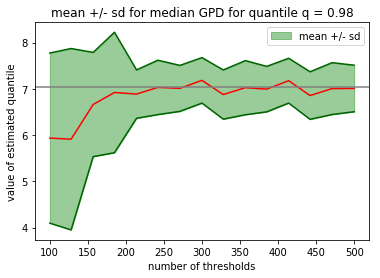

<Figure size 432x288 with 0 Axes>

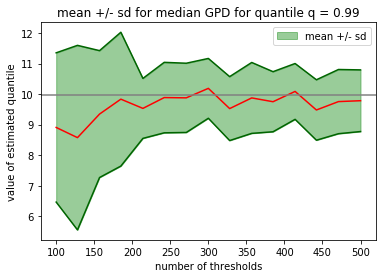

<Figure size 432x288 with 0 Axes>

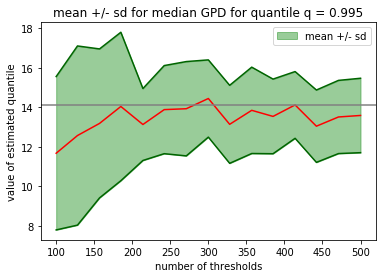

<Figure size 432x288 with 0 Axes>

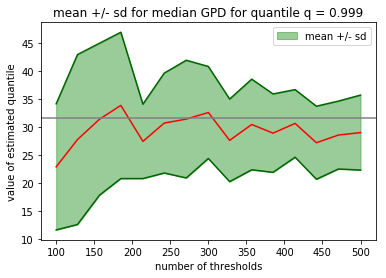

<Figure size 432x288 with 0 Axes>

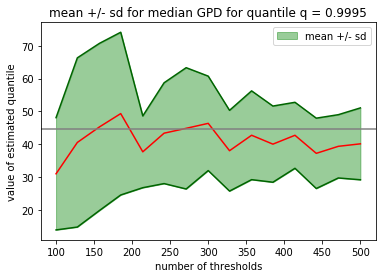

<Figure size 432x288 with 0 Axes>

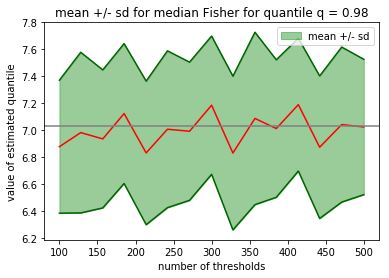

<Figure size 432x288 with 0 Axes>

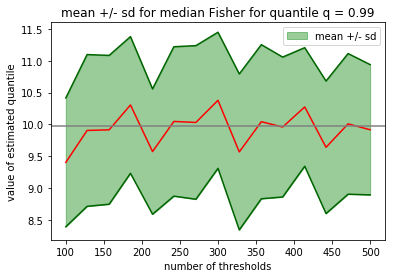

<Figure size 432x288 with 0 Axes>

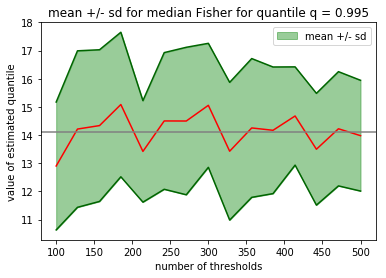

<Figure size 432x288 with 0 Axes>

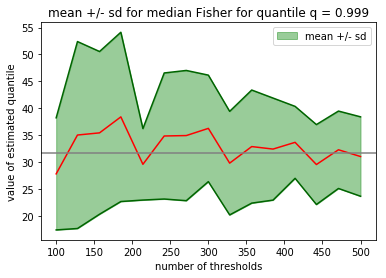

<Figure size 432x288 with 0 Axes>

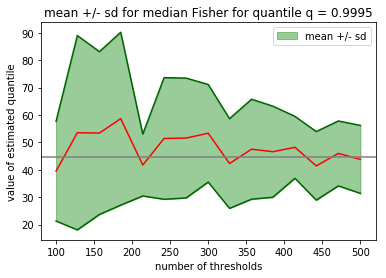

In [15]:
for k in range(len(list1_names)):
    for i in range(len(q)):
        sd, mn = np.zeros(how_many_different_thresholds),np.zeros(how_many_different_thresholds)
        for j in range(how_many_different_thresholds):
            mn[j] = np.mean(list1[k][i].reshape(n,how_many_different_thresholds)[j,:])
            sd[j] = np.sqrt(np.var(list1[k][i].reshape(n,how_many_different_thresholds)[j,:]))
        
        dir_name = str(now.day) + "_" + str(now.month) + "_" + str(now.year) + "_at_" + str(now.hour) + "_" + str(now.minute)
        name = "mean_sd" + str(q[i]) + "_" + list1_names[k]
        script_dir = os.path.dirname('__file__')
        results_dir = os.path.join(script_dir, dir_name + '/')
        sample_file_name = name + '.pdf'
        fig = plt.figure()
        if not os.path.isdir(results_dir): # if the directory does not exist we create it 
            os.makedirs(results_dir)
#         ax = fig.add_subplot(111)
        

        _, ax = plt.subplots()
        ax.plot(jump_excesses,  mn, color = 'red')
        ax.plot(jump_excesses,  mn+sd, 'darkgreen')
        ax.plot(jump_excesses,  mn-sd, 'darkgreen')
        ax.axhline(quant_th[i], xmin=0, xmax=1,color='gray')
        ax.fill_between(jump_excesses, mn+sd, mn-sd, color = 'green', alpha = 0.4, label = 'mean +/- sd')
        title = "mean +/- sd for " + list1_names[k] + " for quantile q = " + str(q[i])
        ax.set_title(title)
        ax.set_xlabel("number of thresholds")
        ax.set_ylabel("value of estimated quantile")
        ax.legend(loc = 'best')
        plt.savefig(results_dir + sample_file_name)
#         fig.savefig(results_dir + sample_file_name )

In [16]:
# plot on the above plots the theoretical values of quantiles quant_th[i]
# plus saving all the plots to put them into ShareLatex